In [2]:
%load_ext autoreload

In [14]:
%autoreload 2

import math
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import torch
import tqdm
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader

from estuary.model.data import EstuaryDataModule, EstuaryDataset, _load_labels, parse_dt_from_pth
from estuary.model.module import EstuaryModule
from estuary.util import broad_band, false_color

In [4]:
module = EstuaryModule.load_from_checkpoint(
    "/Users/kyledorman/data/results/estuary/train/20251008-151833/checkpoints/epoch=15-step=704.ckpt",
    accelerator="cpu",
    workers=0,
    persistent_workers=False,
    batch_size=1,
    prefetch_factor=0,
    strict=False,
)
module = module.eval()

In [5]:
dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()

Some label classes will be ignored {'unsure'}


In [6]:
dl = dm.val_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

thresholds = np.linspace(0, 1, 101)  # e.g., 0.00, 0.01, ..., 1.00
scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0.0)
    rec = recall_score(y_true, y_pred)
    scores.append((t, f1, acc, prec, rec))

# put into DataFrame for analysis
df_scores = pd.DataFrame(scores, columns=["threshold", "f1", "accuracy", "precision", "recall"])

# best threshold by F1
best_f1_row = df_scores.loc[df_scores["f1"].idxmax()]
print(best_f1_row)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 859/859 [00:20<00:00, 41.01it/s]


threshold    0.520000
f1           0.962025
accuracy     0.951106
precision    0.951699
recall       0.972578
Name: 52, dtype: float64


(array([254.,  13.,  14.,   9.,   7.,  10.,   6.,  20.,  30., 496.]),
 array([4.12188956e-06, 9.99896526e-02, 1.99975193e-01, 2.99960732e-01,
        3.99946243e-01, 4.99931782e-01, 5.99917293e-01, 6.99902833e-01,
        7.99888372e-01, 8.99873912e-01, 9.99859452e-01]),
 <BarContainer object of 10 artists>)

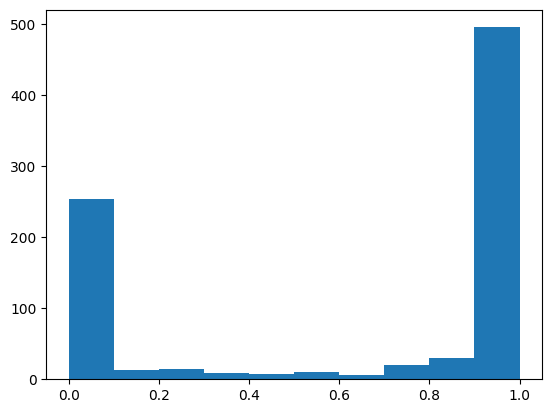

In [7]:
plt.hist(y_prob)

<Axes: xlabel='threshold', ylabel='f1'>

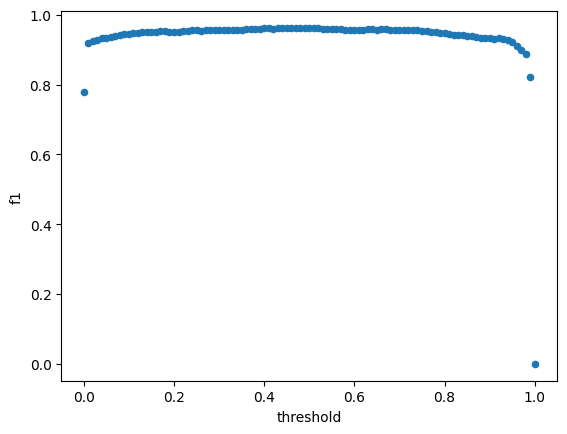

In [8]:
df_scores.plot.scatter(x="threshold", y="f1")

In [9]:
df_scores[df_scores.threshold == 0.5]

,threshold,f1,accuracy,precision,recall
50,0.5,0.961226,0.949942,0.948399,0.974406


In [16]:
results_df = []

In [17]:
dl = dm.val_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "val",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:16<00:00, 40.29it/s]


0.972181551976574

In [18]:
dl = dm.test_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "test",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:18<00:00, 36.89it/s]


0.9554896142433235

In [19]:
dl = dm.train_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5665/5665 [02:01<00:00, 46.44it/s]


0.9816416593115622

In [20]:
results_df = pd.DataFrame(results_df)
results_df["correct"] = results_df.y_true == results_df.y_pred

results_df.head(5)

,source_tif,y_true,y_prob,y_pred,region,dataset,correct
0,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000135,0,16,val,True
1,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000168,0,16,val,True
2,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000164,0,16,val,True
3,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000160,0,16,val,True
4,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000699,0,16,val,True


In [23]:
# Group by region and compute accuracy
acc_by_region = results_df.groupby("region").correct.mean()
open_pct = results_df.groupby("region").y_true.mean().astype(np.float32)
dataset = results_df.groupby("region").dataset.first()

# Combine into a DataFrame for display
acc_df = pd.DataFrame(
    {
        "accuracy": acc_by_region,
        "open_pct": open_pct,
        "dataset": dataset,
    }
).reset_index()

# Show the result
region_stats = acc_df.set_index("region").sort_values(by="accuracy")

region_stats.head(5).round(2)

,accuracy,open_pct,dataset
region,,,
58,0.88,0.44,train
11,0.89,0.93,test
52,0.89,0.57,train
27,0.90,0.49,test
45,0.93,0.54,train


In [24]:
region_stats[region_stats.accuracy < 0.9].round(2)

,accuracy,open_pct,dataset
region,,,
58,0.88,0.44,train
11,0.89,0.93,test
52,0.89,0.57,train


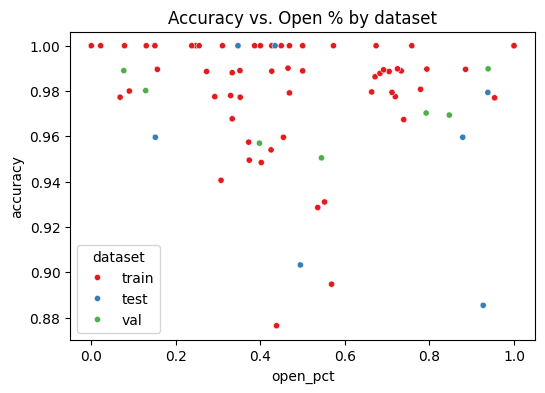

In [25]:
# df has columns: accuracy, open_pct, dataset
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=region_stats,
    x="open_pct",
    y="accuracy",
    hue="dataset",  # color by dataset
    palette="Set1",  # you can pick another palette
    s=20,  # point size
)
plt.title("Accuracy vs. Open % by dataset")
plt.show()

In [26]:
N = 5
best_counts = region_stats.tail(N)
worse_counts = region_stats.head(N)

display(worse_counts.round(2))

,accuracy,open_pct,dataset
region,,,
58,0.88,0.44,train
11,0.89,0.93,test
52,0.89,0.57,train
27,0.90,0.49,test
45,0.93,0.54,train


In [27]:
region_stats[region_stats.dataset == "test"].round(2)

,accuracy,open_pct,dataset
region,,,
11,0.89,0.93,test
27,0.90,0.49,test
72,0.96,0.88,test
18,0.96,0.15,test
15,0.98,0.94,test
48,1.00,0.43,test
50,1.00,0.35,test


In [28]:
region_stats[region_stats.dataset == "val"].round(2)

,accuracy,open_pct,dataset
region,,,
2145,0.95,0.54,val
77,0.96,0.40,val
21,0.97,0.85,val
56,0.97,0.79,val
25,0.98,0.13,val
16,0.99,0.08,val
51,0.99,0.94,val


In [31]:
gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf[gdf["Site code"].isin(region_stats[region_stats.dataset == "test"].index)]

,Site code,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
0,11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933)
4,15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231)
7,18,34.015,-118.821,North America,USA,Zuma Lagoon,0,None,None,None,None,POINT (-118.821 34.015)
16,27,34.413,-119.687,North America,USA,Mission Creek,0,MISSION C BL W GUTIERREZ ST BR A SANTA BARBARA CA,11119770,34.41421944,-119.6958472,POINT (-119.687 34.413)
37,48,36.537,-121.927,North America,USA,Carmel River,1,None,None,None,None,POINT (-121.927 36.537)
39,50,36.748,-121.801,North America,USA,Salinas River,1,None,None,None,None,POINT (-121.801 36.748)
61,72,38.451,-123.128,North America,USA,Russian River,1,RUSSIAN R A HIGHWAY 1 BRIDGE NR JENNER CA,11467270,38.4340222,-123.1011083,POINT (-123.128 38.451)


In [32]:
def image_iter(df, dataset, count):
    fdf = df[(df["dataset"] == dataset) & ~df.correct]
    for region, gdf in fdf.groupby("region"):
        group = []
        for _, row in gdf.iterrows():
            group.append((row.source_tif, row.y_true))
            if len(group) == count:
                yield region, group
                group = []
        if len(group):
            yield region, group


val_iter = image_iter(results_df, "val", 6)
test_iter = image_iter(results_df, "test", 6)
train_iter = image_iter(results_df, "train", 6)

In [40]:
region, images = next(val_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    ax.set_axis_off()

    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    label = "Closed" if y_true == 0 else "Open"
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

StopIteration: 

In [48]:
region, images = next(test_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    label = "Closed" if y_true == 0 else "Open"
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

StopIteration: 

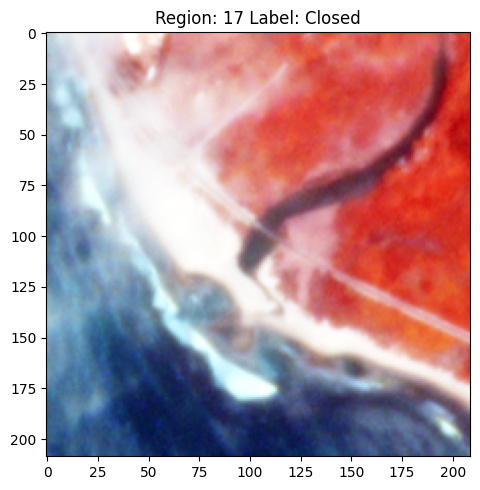

In [51]:
region, images = next(train_iter)

assert len(images), region

cols = min(len(images), 3)
rows = max(1, min(math.ceil(len(images) // 2), 2))
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))

if len(images) == 1:
    axs = [[axs]]
elif rows == 1:
    axs = [axs]
axs = [ax for axx in axs for ax in axx]
for (source_tif, y_true), ax in zip(images, axs, strict=False):
    with rasterio.open(source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    label = "Closed" if y_true == 0 else "Open"
    ax.imshow(img)
    ax.set_title(f"Region: {region} Label: {label}")

plt.tight_layout()
plt.show()

In [52]:
all_labels = _load_labels(module.conf.classes, module.conf.data)
results_df = pd.merge(
    results_df, all_labels[["source_tif", "orig_label"]], on="source_tif", how="left"
)

Some label classes will be ignored {'unsure'}


In [ ]:
# for _, row in tqdm.tqdm(
#     results_df[~results_df.correct].iterrows(), total=(~results_df.correct).sum()
# ):
#     label = "_".join(row.orig_label.split(" "))
#     with rasterio.open(row.source_tif) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         img = Image.fromarray(img)

#     save_dir = Path("/Volumes/x10pro/estuary/ca_all/inspect_all_sites/") / label
#     save_dir.mkdir(exist_ok=True, parents=True)
#     img.save(save_dir / f"{Path(row.source_tif).stem}.jpg")

In [53]:
ca_all_labels = _load_labels(
    module.conf.classes, "/Volumes/x10pro/estuary/ca_all/dove/labeling/labels.csv"
)
ca_results_list = []

ds = EstuaryDataset(
    df=ca_all_labels,
    conf=module.conf,
    train=False,
)
dl = DataLoader(
    ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = ds.transforms(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        ca_results_list.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[1].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

Some label classes will be ignored {'unsure'}
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:23<00:00, 56.36it/s]


0.9500745156482862

In [54]:
ca_results_df = pd.DataFrame(ca_results_list)
ca_results_df = pd.merge(
    ca_results_df, ca_all_labels[["source_tif", "orig_label"]], on="source_tif", how="left"
)
ca_results_df["correct"] = ca_results_df.y_true == ca_results_df.y_pred
ca_results_df.head()

,source_tif,y_true,y_prob,y_pred,region,dataset,orig_label,correct
0,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.980015,1,2145,train,open,True
1,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999822,1,2145,train,open,True
2,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999904,1,2145,train,open,True
3,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.998268,1,2145,train,open,True
4,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999974,1,2145,train,open,True


In [55]:
ca_results_df.groupby("orig_label").correct.mean()

orig_label
closed          0.983974
open            0.955725
perched open    0.555556
Name: correct, dtype: float64

In [ ]:
# for _, row in tqdm.tqdm(
#     ca_results_df[~ca_results_df.correct].iterrows(), total=(~ca_results_df.correct).sum()
# ):
#     label = "_".join(row.orig_label.split(" "))
#     with rasterio.open(row.source_tif) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         img = Image.fromarray(img)

#     save_dir = Path("/Volumes/x10pro/estuary/ca_all/inspect/") / label
#     save_dir.mkdir(exist_ok=True, parents=True)
#     img.save(save_dir / f"{Path(row.source_tif).stem}.jpg")

In [68]:
df = pd.read_csv("/Volumes/x10pro/estuary/dove/labels.csv")
df["dove_type"] = df.source_tif.apply(lambda a: Path(a).parents[5].name)
df["year"] = df.source_tif.apply(lambda a: int(Path(a).parents[3].name))
df

,region,source_tif,label,acquired,instrument,dove_type,year
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,dove,superdove,2022
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,dove,superdove,2022
2,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-07-10 18:21:59,dove,superdove,2022
3,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-06-09 18:05:19,dove,superdove,2022
4,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-01-01 18:06:34,dove,superdove,2022
...,...,...,...,...,...,...,...
7557,32,/Volumes/x10pro/estuary/dove/results/2018/4/32...,open,2018-04-04 18:31:00,dove,dove,2018
7558,32,/Volumes/x10pro/estuary/dove/results/2018/3/32...,closed,2018-03-05 18:10:24,dove,dove,2018
7559,32,/Volumes/x10pro/estuary/dove/results/2018/12/3...,closed,2018-12-01 18:20:54,dove,dove,2018
7560,32,/Volumes/x10pro/estuary/dove/results/2018/2/32...,closed,2018-02-04 18:08:44,dove,dove,2018


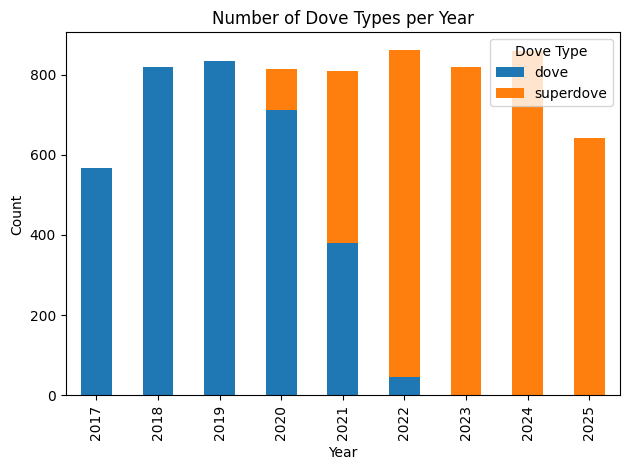

In [70]:
# Count occurrences by year and dove_type
counts = df[df.label != "unsure"].groupby(["year", "dove_type"]).size().unstack(fill_value=0)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True)

plt.title("Number of Dove Types per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Dove Type")
plt.tight_layout()
plt.show()

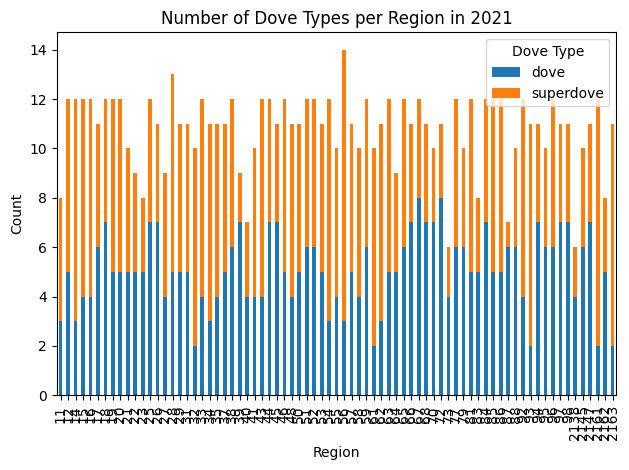

In [72]:
# Count occurrences by year and dove_type
counts = (
    df[(df.label != "unsure") & (df.year == 2021)]
    .groupby(["region", "dove_type"])
    .size()
    .unstack(fill_value=0)
)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True)

plt.title("Number of Dove Types per Region in 2021")
plt.xlabel("Region")
plt.ylabel("Count")
plt.legend(title="Dove Type")
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd


def hysteresis_decode(
    times: pd.Series,  # datetime-like, sorted
    probs: np.ndarray,  # p(open) in [0,1], same length as times
    T_high: float = 0.65,  # enter-open threshold
    T_low: float = 0.45,  # exit-open threshold
    min_run: int = 2,  # minimum samples to keep a new state (dwell)
    gap_reset_hours: float = 96.0,  # reset state across large gaps
) -> np.ndarray:
    """
    Returns a 0/1 numpy array of states (0=closed, 1=open) using hysteresis.
    - Start state chosen by first non-NaN prob with T_high/T_low logic.
    - If a flip occurs, it must persist for `min_run` samples or it is reverted.
    - Across gaps > gap_reset_hours, state is re-initialized (no carry-over).
    """
    assert len(times) == len(probs)
    n = len(probs)
    states = np.zeros(n, dtype=np.int8)

    # Precompute gaps
    t = pd.to_datetime(times).reset_index(drop=True)
    dts = t.diff().dt.total_seconds().fillna(0).to_numpy()
    gap_thresh = gap_reset_hours * 3600.0

    # Helper: pick initial state from a probability value
    def init_from_p(p):
        if np.isnan(p):  # unknown -> default closed
            return 0
        if p >= T_high:  # confidently open
            return 1
        if p <= T_low:  # confidently closed
            return 0
        # undecided region: default closed (tunable)
        return 0

    # Initialize first segment
    states[0] = init_from_p(probs[0])
    cur = states[0]
    run_len = 1  # current run length in `cur` state

    for i in range(1, n):
        # Reset across large gaps
        if dts[i] > gap_thresh:
            cur = init_from_p(probs[i])
            states[i] = cur
            run_len = 1
            continue

        p = probs[i]
        prev = cur

        # Hysteresis rule
        if cur == 1:
            # currently open; need strong evidence to close
            cur = 0 if (not np.isnan(p) and p <= T_low) else 1
        else:
            # currently closed; need strong evidence to open
            cur = 1 if (not np.isnan(p) and p >= T_high) else 0

        if cur == prev:
            run_len += 1
            states[i] = cur
        else:
            # Tentative flip: enforce minimum duration
            # Look ahead up to min_run samples (bounded by array end and gaps)
            end = i + min_run
            # Stop early if a large gap occurs in the lookahead window
            j = i
            ok = True
            while j < min(end, n):
                if j > i and dts[j] > gap_thresh:
                    ok = False  # do not enforce across a gap; cancel flip
                    break
                pj = probs[j]
                # Must keep satisfying the hysteresis condition in the new state
                if cur == 1 and (np.isnan(pj) or pj < T_high):
                    ok = False
                    break
                if cur == 0 and (np.isnan(pj) or pj > T_low):
                    ok = False
                    break
                j += 1

            if ok and j <= n:
                # Commit flip: fill the run [i, j-1] with new state
                states[i:j] = cur
                run_len = j - i
                # Continue from j-1 as last written; loop moves to j next
                # (we won't skip indices; we just set current state here)
            else:
                # Cancel flip, keep previous state
                cur = prev
                states[i] = cur
                run_len += 1

    return states

In [40]:
def extract_changes(
    times: pd.Series, states: np.ndarray, gap_reset_hours: float = 60.0
) -> list[pd.Timestamp]:
    """Return timestamps where state changes (0↔1). Resets across large gaps."""
    t = pd.to_datetime(times).reset_index(drop=True)
    dts = t.diff().dt.total_seconds().fillna(0)
    gap_s = gap_reset_hours * 3600.0
    changes: List[pd.Timestamp] = []

    prev_state = int(states[0])
    for i in range(1, len(states)):
        if dts.iat[i] > gap_s:
            prev_state = int(states[i])  # re-init segment
            continue
        s = int(states[i])
        if s != prev_state:
            changes.append(t.iat[i])  # mark change time at boundary sample
            prev_state = s
    return changes

In [49]:
from dataclasses import dataclass


@dataclass
class MatchResult:
    tp: int
    fp: int
    fn: int
    matched_pairs: list[tuple[pd.Timestamp, pd.Timestamp, pd.Timedelta]]  # (gt, pred, diff)
    mae_days: float | None


def match_events_with_tolerance(
    gt_events: list[pd.Timestamp], pred_events: list[pd.Timestamp], tol_days: float = 3.0
) -> MatchResult:
    """Greedy nearest-neighbor matching within ±tol_days (one-to-one)."""
    tol = pd.Timedelta(days=tol_days)
    gt_sorted = sorted(pd.to_datetime(gt_events))
    pr_sorted = sorted(pd.to_datetime(pred_events))

    used_pred = set()
    pairs: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timedelta]] = []

    for gt in gt_sorted:
        # find closest unused pred within tolerance
        best = None
        best_abs = None
        for j, pr in enumerate(pr_sorted):
            if j in used_pred:
                continue
            diff = pr - gt
            if abs(diff) <= tol:
                ad = abs(diff)
                if best_abs is None or ad < best_abs:
                    best = (j, pr, diff)
                    best_abs = ad
        if best is not None:
            j, pr, diff = best
            used_pred.add(j)
            pairs.append((gt, pr, diff))

    tp = len(pairs)
    fn = len(gt_sorted) - tp
    fp = len(pr_sorted) - tp
    mae_days = (
        float(np.mean([abs(d).days + abs(d).seconds / 86400 for _, _, d in pairs]))
        if pairs
        else None
    )
    return MatchResult(tp=tp, fp=fp, fn=fn, matched_pairs=pairs, mae_days=mae_days)

In [51]:
tdf = pd.read_csv(
    "/Users/kyledorman/data/results/estuary/train/20251008-161940/timeseries_preds.csv"
)
tdf["acquired"] = tdf.source_tif.apply(lambda a: parse_dt_from_pth(Path(a)))
tdf = tdf.sort_values("acquired").reset_index(drop=True)
print(tdf.region.unique())
rdf = tdf[tdf.region == 2145]
time_preds = hysteresis_decode(
    rdf.acquired,
    rdf.y_prob.to_numpy(),
    T_high=0.8,
    T_low=0.2,
)

print(rdf.correct.mean())
print((time_preds == rdf.y_true.to_numpy()).mean())

[  51   21 2145   28   84   48   43]
0.9783904619970194
0.977645305514158


In [53]:
result = match_events_with_tolerance(
    extract_changes(rdf.acquired, rdf.y_true.to_numpy()),
    extract_changes(rdf.acquired, rdf.y_pred.to_numpy()),
)

print(result.tp, result.fp)

result = match_events_with_tolerance(
    extract_changes(rdf.acquired, rdf.y_true.to_numpy()), extract_changes(rdf.acquired, time_preds)
)

print(result.tp, result.fp)

9 9
7 1


In [54]:
len(extract_changes(rdf.acquired, rdf.y_true.to_numpy()))

26